In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage import transform as tf

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
import healpy as hp
from astropy.coordinates import Angle


In [22]:
w = WCS(naxis=2)

skydir = SkyCoord(0, 0, unit='deg', frame='galactic')

width=2000
height=1000
fov="3 deg"
fov = Angle(fov)
crpix = (float(height / 2), float(width / 2))
cdelt = float(fov.degree) / float(max(height, width))


w.wcs.ctype[0] = 'GLON-{}'.format('AIT')
w.wcs.ctype[1] = 'GLAT-{}'.format('AIT')
w.wcs.crval[0] = skydir.galactic.l.deg
w.wcs.crval[1] = skydir.galactic.b.deg

w.wcs.crpix[0] = crpix[0]
w.wcs.crpix[1] = crpix[1]

w.wcs.cdelt[0] = -cdelt
w.wcs.cdelt[1] = cdelt

w = WCS(w.to_header())

shape = (1000, 2000)
all_sky_wcs = w

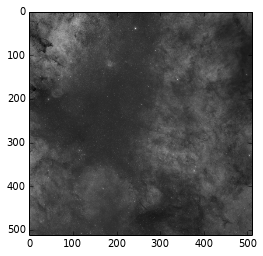

In [24]:
# hdu_list = fits.open('https://rawgithub.com/hipspy/hips-extra/master/datasets/samples/DSS2Red/Norder3/Dir0/Npix335.fits')
hdu_list = fits.open('https://rawgithub.com/hipspy/hips-extra/master/datasets/samples/DSS2Red/Norder3/Dir0/Npix450.fits')

tile_wcs = WCS(hdu_list[0].header)
tile = hdu_list[0].data.astype('float')
plt.imshow(tile, cmap='gray')
plt.show()

In [26]:
def compute_corners_skycoord(order, ipix):
    nside = hp.order2nside(order)
    coords = hp.boundaries(nside, ipix, nest=True)
    theta, phi = hp.vec2ang(np.transpose(coords), lonlat=False)
    radec = SkyCoord(ra=phi, dec=np.pi/2 - theta, unit='radian', frame='icrs')
    print('SkyCoord :', radec.galactic)
    pixels = np.array(radec.to_pixel(all_sky_wcs))
    return (pixels.T.reshape((4,2)))


In [27]:
from skimage import transform as tf
def draw_tile(warped, corners, out_shape):
    src = corners
    print('Source : ', src)
    dst = np.array([[511, 0], [511, 511], [0, 511], [0, 0]])
    tform3 = tf.ProjectiveTransform()
    tform3.estimate(src, dst)
    return warped + tf.warp(tile, tform3, output_shape=out_shape)


SkyCoord : <SkyCoord (Galactic): (l, b) in deg
    [(   2.70907683,  3.81383515), ( 355.44356947,  4.98219156),
     ( 353.36235549, -2.10918264), (   0.67390004, -3.23622577)]>
Corners:  [[ -804.00799183  3041.26480977]
 [ 4027.80520568  3820.06978065]
 [ 5421.22862529  -907.63207223]
 [  550.27147699 -1658.20638199]]
Source :  [[ -804.00799183  3041.26480977]
 [ 4027.80520568  3820.06978065]
 [ 5421.22862529  -907.63207223]
 [  550.27147699 -1658.20638199]]


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


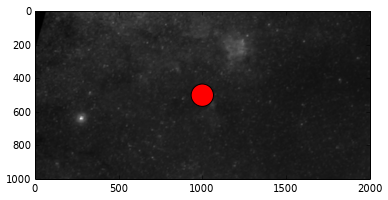

In [28]:
from astropy.visualization.wcsaxes import WCSAxes
warped = np.zeros((1000, 2000)) # the output image size

indices = [450]
for index in indices:
    corners = compute_corners_skycoord(3, index)
    print('Corners: ', corners)
    warped = draw_tile(warped, corners, warped.shape)

plt.scatter(1000, 500, s=500, c='red', marker='o')
plt.imshow(warped, origin='upper', cmap=plt.cm.gray)